In [9]:
import mysql.connector
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
from faker import Faker

# 在文件开头添加以下代码（在所有import之后）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [10]:
# 数据库配置
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'MySQL2025',
    'database': 'rail'
}

In [11]:
# 初始化Faker生成测试数据
fake = Faker('zh_CN')

def initialize_database():
    """初始化数据库，创建表结构"""
    try:
        conn = mysql.connector.connect(**db_config)
        cursor = conn.cursor()
        
        # 删除旧表（如果存在）
        cursor.execute("DROP TABLE IF EXISTS Users")
        
        # 创建用户表（移除了Username的唯一约束）
        cursor.execute("""
        CREATE TABLE Users (
          UserID INT NOT NULL AUTO_INCREMENT,
          Username VARCHAR(50) NOT NULL,
          PASSWORD VARCHAR(100) NOT NULL,
          RealName VARCHAR(50) NOT NULL,
          IDCard VARCHAR(18) NOT NULL,
          Phone VARCHAR(20),
          Email VARCHAR(100),
          Gender TINYINT NOT NULL,
          RegisterTime DATETIME NOT NULL DEFAULT CURRENT_TIMESTAMP,
          PRIMARY KEY (UserID),
          UNIQUE KEY (IDCard),  -- 只保留IDCard的唯一约束
          CONSTRAINT chk_gender CHECK (Gender IN (0,1)),
          CONSTRAINT chk_idcard_length CHECK (LENGTH(IDCard) = 18)
        ) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
        """)
        
        print("数据库初始化完成")
        cursor.close()
        conn.close()
    except Exception as e:
        print(f"初始化数据库时出错: {e}")
        raise

def generate_test_data(num_records):
    """生成测试数据（优化版，只保证IDCard唯一）"""
    users = []
    idcards = set()
    
    # 预先生成足够多的唯一身份证号
    while len(idcards) < num_records:
        idcards.add(fake.ssn())
    
    idcards = list(idcards)
    
    # 批量生成用户数据
    for i in range(num_records):
        gender = random.randint(0, 1)
        name = fake.name_male() if gender == 1 else fake.name_female()
        
        users.append({
            'username': f"user_{i}",  # 简单的用户名，不需要唯一
            'password': 'e10adc3949ba59abbe56e057f20f883e',  # 123456的MD5
            'realname': name,
            'idcard': idcards[i],  # 使用预生成的唯一身份证号
            'phone': fake.phone_number(),
            'email': f"user_{i}@example.com",
            'gender': gender
        })
    
    return users

def insert_test_data(users):
    """插入测试数据（优化版，批量插入+事务控制）"""
    try:
        conn = mysql.connector.connect(**db_config)
        cursor = conn.cursor()
        
        # 禁用自动提交提高性能
        conn.autocommit = False
        
        # 清空表（快速方式）
        cursor.execute("TRUNCATE TABLE Users")
        
        # 批量插入数据（每次1000条）
        batch_size = 1000
        insert_sql = """
        INSERT INTO Users (Username, PASSWORD, RealName, IDCard, Phone, Email, Gender)
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        """
        
        start_time = time.time()
        
        for i in range(0, len(users), batch_size):
            batch = users[i:i+batch_size]
            # 转换为元组列表
            data = [(u['username'], u['password'], u['realname'], 
                     u['idcard'], u['phone'], u['email'], u['gender']) for u in batch]
            cursor.executemany(insert_sql, data)
            conn.commit()
            print(f"已插入 {min(i+batch_size, len(users))}/{len(users)} 条记录")
        
        end_time = time.time()
        
        print(f"总共插入 {len(users)} 条记录，耗时: {end_time - start_time:.4f} 秒")
        
        cursor.close()
        conn.close()
        return end_time - start_time
    except Exception as e:
        conn.rollback()
        print(f"插入数据时出错: {e}")
        raise

def query_without_index(idcard, repeat=10):
    """无索引查询测试"""
    try:
        conn = mysql.connector.connect(**db_config)
        cursor = conn.cursor()
        
        # 确保没有IDCard索引
        cursor.execute("SHOW INDEX FROM Users WHERE Column_name = 'IDCard'")
        if cursor.fetchone():
            cursor.execute("DROP INDEX IDCard ON Users")
            conn.commit()
        
        query_sql = "SELECT * FROM Users WHERE IDCard = %s"
        
        # 预热并确保查询有效
        cursor.execute(query_sql, (idcard,))
        result = cursor.fetchall()
        if not result:
            raise ValueError("测试IDCard不存在于数据库中")
        
        # 正式测试
        start_time = time.time()
        for _ in range(repeat):
            cursor.execute(query_sql, (idcard,))
            cursor.fetchall()  # 确保读取所有结果
        end_time = time.time()
        
        avg_time = (end_time - start_time) / repeat
        
        cursor.close()
        conn.close()
        return avg_time
    except Exception as e:
        print(f"无索引查询时出错: {e}")
        raise

def query_with_index(idcard, repeat=10):
    """有索引查询测试"""
    try:
        conn = mysql.connector.connect(**db_config)
        cursor = conn.cursor()
        
        # 确保有IDCard索引
        cursor.execute("SHOW INDEX FROM Users WHERE Column_name = 'IDCard'")
        if not cursor.fetchone():
            cursor.execute("CREATE INDEX IDCard ON Users (IDCard)")
            conn.commit()
        
        query_sql = "SELECT * FROM Users WHERE IDCard = %s"
        
        # 预热并确保查询有效
        cursor.execute(query_sql, (idcard,))
        result = cursor.fetchall()
        if not result:
            raise ValueError("测试IDCard不存在于数据库中")
        
        # 正式测试
        start_time = time.time()
        for _ in range(repeat):
            cursor.execute(query_sql, (idcard,))
            cursor.fetchall()  # 确保读取所有结果
        end_time = time.time()
        
        avg_time = (end_time - start_time) / repeat
        
        cursor.close()
        conn.close()
        return avg_time
    except Exception as e:
        print(f"有索引查询时出错: {e}")
        raise


# 然后修改visualize_results函数如下：
def visualize_results(results):
    """可视化实验结果（已解决中文乱码问题）"""
    if not results:
        print("没有可用的实验结果")
        return
    
    df = pd.DataFrame(results)
    
    # 创建画布
    plt.figure(figsize=(12, 6), dpi=100)
    
    # 查询时间对比图
    plt.subplot(1, 2, 1)
    plt.plot(df['data_size'], df['query_without_index'], 'r-', label='无索引查询')
    plt.plot(df['data_size'], df['query_with_index'], 'g-', label='有索引查询')
    plt.xlabel('数据量（条）', fontsize=10)
    plt.ylabel('平均查询时间（秒）', fontsize=10)
    plt.title('索引对查询性能的影响', fontsize=12)
    plt.legend(fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 插入时间图
    plt.subplot(1, 2, 2)
    plt.plot(df['data_size'], df['insert_time'], 'b-', label='数据插入时间')
    plt.xlabel('数据量（条）', fontsize=10)
    plt.ylabel('插入时间（秒）', fontsize=10)
    plt.title('数据插入时间', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 调整布局并保存
    plt.tight_layout()
    plt.savefig('index_performance_comparison_large.png', bbox_inches='tight', dpi=300)
    print("实验结果图表已保存为 index_performance_comparison.png")
    plt.show()
    
    # 保存结果到CSV
    df.to_csv('experiment_results_large.csv', index=False, encoding='utf_8_sig')  # 使用UTF-8带BOM编码
    print("实验数据已保存为 experiment_results.csv")

def run_experiment():
    """运行完整实验（调整数据规模）"""
    # 调整测试数据规模（从小的开始，逐步增加）
    data_sizes = [100, 1000, 5000, 10000, 50000, 100000, 1000000]  # 先测试较小规模
    
    results = {
        'data_size': [],
        'insert_time': [],
        'query_without_index': [],
        'query_with_index': []
    }
    
    try:
        for size in data_sizes:
            print(f"\n=== 正在测试数据规模: {size} ===")
            
            print(f"生成测试数据...")
            test_users = generate_test_data(size)
            test_idcard = test_users[0]['idcard']
            
            print(f"插入数据...")
            insert_time = insert_test_data(test_users)
            
            print(f"执行无索引查询测试...")
            query_time_no_index = query_without_index(test_idcard)
            
            print(f"执行有索引查询测试...")
            query_time_with_index = query_with_index(test_idcard)
            
            # 记录结果
            results['data_size'].append(size)
            results['insert_time'].append(insert_time)
            results['query_without_index'].append(query_time_no_index)
            results['query_with_index'].append(query_time_with_index)
            
            print(f"\n结果 - 数据量: {size}")
            print(f"插入时间: {insert_time:.4f}s")
            print(f"无索引查询: {query_time_no_index:.6f}s")
            print(f"有索引查询: {query_time_with_index:.6f}s")
        
        return results
    except Exception as e:
        print(f"实验过程中出错: {e}")
        return None

数据库初始化完成

=== 正在测试数据规模: 100 ===
生成测试数据...
插入数据...
已插入 100/100 条记录
总共插入 100 条记录，耗时: 0.0175 秒
执行无索引查询测试...
执行有索引查询测试...

结果 - 数据量: 100
插入时间: 0.0175s
无索引查询: 0.001007s
有索引查询: 0.000843s

=== 正在测试数据规模: 1000 ===
生成测试数据...
插入数据...
已插入 1000/1000 条记录
总共插入 1000 条记录，耗时: 0.1054 秒
执行无索引查询测试...
执行有索引查询测试...

结果 - 数据量: 1000
插入时间: 0.1054s
无索引查询: 0.002713s
有索引查询: 0.000690s

=== 正在测试数据规模: 5000 ===
生成测试数据...
插入数据...
已插入 1000/5000 条记录
已插入 2000/5000 条记录
已插入 3000/5000 条记录
已插入 4000/5000 条记录
已插入 5000/5000 条记录
总共插入 5000 条记录，耗时: 0.5186 秒
执行无索引查询测试...
执行有索引查询测试...

结果 - 数据量: 5000
插入时间: 0.5186s
无索引查询: 0.007108s
有索引查询: 0.000702s

=== 正在测试数据规模: 10000 ===
生成测试数据...
插入数据...
已插入 1000/10000 条记录
已插入 2000/10000 条记录
已插入 3000/10000 条记录
已插入 4000/10000 条记录
已插入 5000/10000 条记录
已插入 6000/10000 条记录
已插入 7000/10000 条记录
已插入 8000/10000 条记录
已插入 9000/10000 条记录
已插入 10000/10000 条记录
总共插入 10000 条记录，耗时: 0.8257 秒
执行无索引查询测试...
执行有索引查询测试...

结果 - 数据量: 10000
插入时间: 0.8257s
无索引查询: 0.012588s
有索引查询: 0.000878s

=== 正在测试数据规模: 50000 ===
生成测试数据...
插入数据.

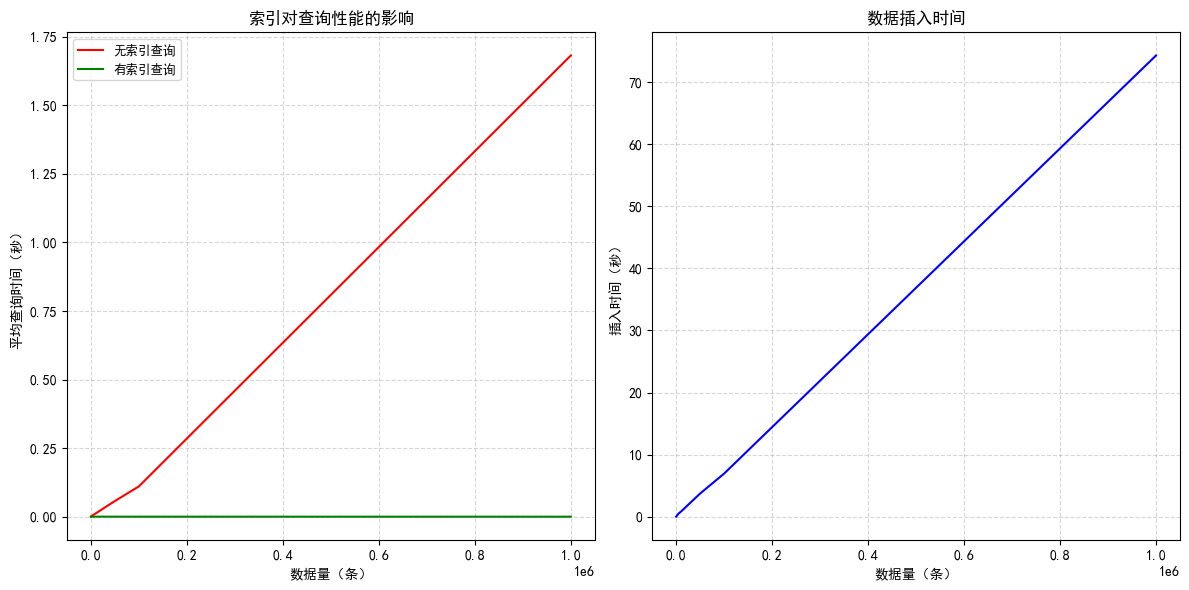

实验数据已保存为 experiment_results.csv


In [12]:
if __name__ == "__main__":
    try:
        initialize_database()
        results = run_experiment()
        if results:
            visualize_results(results)
        else:
            print("实验失败，请检查错误信息")
    except Exception as e:
        print(f"程序运行出错: {e}")